<a href="https://colab.research.google.com/github/SuperLuFi/SRP-DATA/blob/main/Core_2D_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Depth 0 cm selesai, lambda: 0.78363
✅ Depth 4 cm selesai, lambda: 0.77896
✅ Depth 8 cm selesai, lambda: 0.76677
✅ Depth 12 cm selesai, lambda: 0.74797
✅ Depth 16 cm selesai, lambda: 0.72411
✅ Depth 20 cm selesai, lambda: 0.69770
✅ Depth 24 cm selesai, lambda: 0.67278
✅ Depth 28 cm selesai, lambda: 0.65399
✅ Depth 32 cm selesai, lambda: 0.64345
✅ Depth 36 cm selesai, lambda: 0.63941
✅ Depth 40 cm selesai, lambda: 0.63861


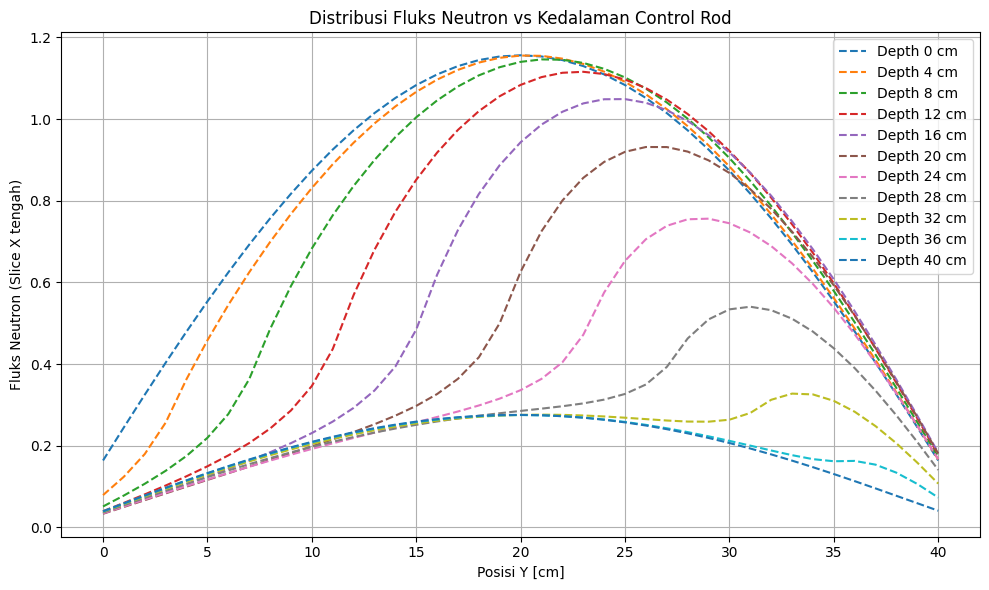

In [1]:
# Simulasi 2D reaktor: pengaruh batang kendali terhadap distribusi fluks neutron

import numpy as np
import matplotlib.pyplot as plt
import gc

# --- PARAMETER GRID & MATERIAL ---
d = 1.0
L = 41.0
vac = 0.0
r = 0.0

n_vac = int(vac / d)
n_r = int(r / d)
n_c = int(L / d)
n = 2 * n_vac + 2 * n_r + n_c

# Konstanta properti material
Dvac = 0.16
Svac = 1e8
Dr = 0.16
Sar = 0.02
Dp = 0.16
Sap = 20.0
Dc = 9.21
Sac = 0.1532
nuSf_val = 0.157

# --- INISIALISASI MATRIKS MATERIAL (2D) ---
nuSf_mac = np.zeros((n+2, n+2))
D_mac = np.zeros((n+2, n+2))
Sa_mac = np.zeros((n+2, n+2))

for i in range(1, n+1):
    if n_vac + n_r < i <= n_vac + n_r + n_c:
        nuSf_mac[i, n_vac + n_r + 1 : n_vac + n_r + n_c + 1] = nuSf_val

    D_mac[i, :] = Dvac
    if n_vac < i <= n_vac + 2*n_r + n_c:
        D_mac[i, n_vac+1 : n+1 - n_vac] = Dr
    if n_vac + n_r < i <= n_vac + n_r + n_c:
        D_mac[i, n_vac + n_r + 1 : n_vac + n_r + n_c + 1] = Dc

    Sa_mac[i, :] = Svac
    if n_vac < i <= n_vac + 2*n_r + n_c:
        Sa_mac[i, n_vac+1 : n+1 - n_vac] = Sar
    if n_vac + n_r < i <= n_vac + n_r + n_c:
        Sa_mac[i, n_vac + n_r + 1 : n_vac + n_r + n_c + 1] = Sac

# Flatten ke vektor 1D
nuSf = nuSf_mac[1:n+1, 1:n+1].flatten()

# --- SIMULASI UNTUK TIAP KEDALAMAN CONTROL ROD ---
plt.figure(figsize=(10, 6))

for y in range(0, n, 4):
    D_temp = np.copy(D_mac)
    Sa_temp = np.copy(Sa_mac)
    x = int(round(n / 2.0))
    for i in range(1 + n_vac, y + 1 + n_vac):
        D_temp[i, x] = Dp
        Sa_temp[i, x] = Sap

    A = np.zeros((n**2, n**2))
    for k in range(n**2):
        i = (k % n) + 1
        j = (k // n) + 1
        if k - n >= 0:
            A[k, k - n] = -0.5 * (D_temp[j, i] + D_temp[j-1, i]) / d**2
        if k - 1 >= 0:
            A[k, k - 1] = -0.5 * (D_temp[j, i] + D_temp[j, i-1]) / d**2
        A[k, k] = (0.5 * (D_temp[j+1, i] + D_temp[j, i+1] + 4 * D_temp[j, i] + D_temp[j, i-1] + D_temp[j-1, i])) / d**2 + Sa_temp[j, i]
        if k + 1 < n**2:
            A[k, k + 1] = -0.5 * (D_temp[j, i] + D_temp[j, i+1]) / d**2
        if k + n < n**2:
            A[k, k + n] = -0.5 * (D_temp[j, i] + D_temp[j+1, i]) / d**2

    # Iterasi power method
    F = np.ones(n**2)
    lmd = 1.0
    eps = 1e-6

    while True:
        S = nuSf * F / lmd
        Fnew = np.linalg.solve(A, S)
        lmd_new = lmd * (np.sum(nuSf * Fnew) / np.sum(nuSf * F))
        if abs((lmd_new - lmd) / lmd_new) < eps:
            break
        lmd = lmd_new
        F = Fnew

    F_mac = F.reshape((n, n))
    plt.plot(F_mac[:, x], '--', label=f'Depth {y} cm')
    print(f'✅ Depth {y} cm selesai, lambda: {lmd:.5f}')

plt.title('Distribusi Fluks Neutron vs Kedalaman Control Rod')
plt.xlabel('Posisi Y [cm]')
plt.ylabel('Fluks Neutron (Slice X tengah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()